In [122]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime


In [396]:
class load_patch: 

    def __init__(self, path):
        self.path = path
        self.load_data(path)
        self.edit_data()
        #self.save_name()
        

#load in new file(s)
    def load_data(self, path):
        path = self.path
        data = loadmat(path)
        self.data = data
        print("total sweeps: " + str(len(data)))
        return data


#save file name as the file date and cell number
    def save_name(self):
        path = self.path 
        filename = os.path.basename(path)  # This will get '20221017_005.mat'
        variable_name = os.path.splitext(filename)[0]  #remove the extension, giving you file name/date ex: '20221017_005' 

        self.variable_name = variable_name
        print(variable_name)
        # Now you can use variable_name in your code
        return variable_name


#get rid of ititial keys 
    def edit_data(self):
        # data = self.load_data()
        #give access to variable names inside functions 
        data = self.data
        
        new_data = data.copy()  # Create a copy of the original dictionary

        for i in range(4):  # Remove the first three keys from the copy
            first_sweep_key = list(new_data.keys())[0]
            new_data.pop(first_sweep_key)

        for i in range(len(new_data.keys())):  
            first_sweep_key = list(new_data.keys())[i]
            first_value = new_data[first_sweep_key]

        self.new_data = new_data
        print('done1')
        return new_data 
        
    #plot all sweeps to look at the data, or just select sweeps at specific time points
    def plot_sweeps(self, start_time, end_time, initial_sweep, final_sweep): 
        
        new_data = self.new_data
        plt.figure(figsize=(10, 6))

        all_sweeps_pA = []
        # Plot pA data over time for each trial
        for trial_name, pA in list(new_data.items())[initial_sweep:final_sweep]:
            pA = np.array(pA).flatten()  # flatten the array becuase it is 2D
            all_sweeps_pA.append(pA)
            times = np.linspace(0, len(pA)/10, len(pA))  # create a time array
            plt.plot(times, pA * 1e12)  # multiplying by 1e12 to convert the unit from A to pA
            #break  # Break the loop after the first iteration
  
        all_sweeps_pA = np.concatenate(all_sweeps_pA)  # Concatenate all sweep arrays to find global min/max
    
    # Dynamically determine the bottom range based on the lowest value across all sweeps
        bottom_range = min(all_sweeps_pA) * 1e12 # Finding the minimum value for ylim
        top_range =  max(all_sweeps_pA) * 1e12 # Finding the maximum value for ylim
        
        #look only at specific time points for your base amp pre stim
        plt.ylim(bottom_range, top_range) # adjust data range in pA
        plt.xlim(start_time, end_time) # adjust this according to your data range in pA


        plt.xlabel('Time (ms)')  # Add a label to the x-axis
        plt.ylabel('Picoamps (pA)')  # Add a label to the y-axis
        plt.title('Base amp')  # Add a title

        plt.grid(True)  
        return('done')
    
    def plot_min_max_sweeps(self, start_time, end_time, initial_sweep, final_sweep): 
        new_data = self.new_data
        plt.figure(figsize=(10, 6))

        min_values = []  # To store minimum values within the time window
        max_values = []  # To store maximum values within the time window

        for trial_name, pA in list(new_data.items())[initial_sweep:final_sweep]:
            pA = np.array(pA).flatten()  # Flatten the array because it is 2D
            times = np.linspace(0, len(pA)/10, len(pA))  # Create a time array
            
            # Find indices that fall within the specified time window
            indices_within_time = (times >= start_time) & (times <= end_time)
            
            # Filter pA values to only those within the specified time window
            pA_filtered = pA[indices_within_time] * 1e12
            
            # Append min and max values from the filtered array
            if len(pA_filtered) > 0:  # Ensure there are elements to avoid min/max errors
                min_values.append(pA_filtered.min())
                max_values.append(pA_filtered.max())

            plt.plot(times, pA * 1e12)  # Plot the original data

        # Use the min and max values found within the time window for ylim
        bottom_range = min(min_values) if min_values else None  # Default to None if no data
        top_range = max(max_values) if max_values else None

        # Adjust data range in pA
        if bottom_range is not None and top_range is not None:
            plt.ylim(bottom_range, top_range)

        # Adjust this according to your data range in pA
        plt.xlim(start_time, end_time)

        plt.xlabel('Time (ms)')  # Add a label to the x-axis
        plt.ylabel('Picoamps (pA)')  # Add a label to the y-axis
        plt.title('Base amp')  # Add a title

        plt.grid(True)
        return 'done'


    def find_peak_amp(self, start_time, end_time, initial_sweep, final_sweep):
        new_data = self.new_data
        
        # Initialize a list to store the average peak amplitudes
        avg_peak_amps = []
        
        # Loop over each sweep
        for trial_name, pA in list(new_data.items())[initial_sweep:final_sweep]:
            pA = np.array(pA).flatten()  
            # pA = np.array(pA)  # Flatten the array because it is 2D

            print(len(pA))
            sweep_data = pA[start_time:end_time] * (10**12)  # Convert to pA and slice the time window
            times = np.linspace(0, len(pA)/10, len(pA))  # Create a time array
            
            plt.plot(times, pA * 1e12)  # Plotting in pA
            
            # Find the index of the peak negative amplitude within the window
            peak_index = np.argmin(sweep_data)
            
            # Calculate indices 5 bins before and after the peak, ensuring we don't go out of bounds
            start_index = max(0, peak_index - 5)
            end_index = min(len(sweep_data), peak_index + 6)  # +6 because the upper bound is exclusive

            # Calculate the average amplitude around the peak
            # avg_amp = np.mean(sweep_data[start_index:end_index])
            print(sweep_data)
            avg_amp = sweep_data[peak_index]
            avg_peak_amps.append(avg_amp)
        
             #look only at specific time points for your base amp pre stim
        plt.ylim(-1000, 800) # adjust data range in pA
        plt.xlim(start_time, end_time) # adjust this according to your data range in pA

        # Show the plot with all sweeps
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude (pA)')
        plt.title('All Sweeps')
        plt.show()
        
        return avg_peak_amps
    



    def find_base_amp(self, start_time, end_time, initial_sweep, final_sweep):
        new_data = self.new_data
        
        # Initialize a list to store the average peak amplitudes
        avg_peak_amps = []
        
        # Loop over each sweep
        for trial_name, pA in list(new_data.items())[initial_sweep:final_sweep]:
            pA = np.array(pA).flatten()  # Flatten the array because it is 2D
            sweep_data = pA[start_time:end_time] * (10**12)  # Convert to pA and slice the time window
            times = np.linspace(0, len(pA)/10, len(pA))  # Create a time array
        
            
            plt.plot(times, pA * 1e12)  # Plotting in pA
            
            # Find the index of the peak negative amplitude within the window
            peak_index = np.argmin(sweep_data)
            
            # Calculate indices 5 bins before and after the peak, ensuring we don't go out of bounds
            start_index = max(0, peak_index - 1)
            end_index = min(len(sweep_data), peak_index + 1)  # +6 because the upper bound is exclusive
            # Calculate the average amplitude around the peak
            avg_amp = np.mean(sweep_data[start_index:end_index])
            avg_peak_amps.append(avg_amp)
        
             #look only at specific time points for your base amp pre stim
        plt.ylim(-1000, 800) # adjust data range in pA
        plt.xlim(start_time, end_time) # adjust this according to your data range in pA

        # Show the plot with all sweeps
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude (pA)')
        plt.title('All Sweeps')
        plt.show()
        
        return avg_peak_amps

    
    #get baseline values for each sweep
    def calculate_baseline(self, baseline_window_start = 50, baseline_window_end = 100):
        baseline_values = []
        new_data = self.new_data
        count = 0
        for key, value in new_data.items():
            count += 1
            #need to average this before making a list of it
            #should be 90 values, each an average over this time period definted 
            baseline_values.append(value[0][baseline_window_start:baseline_window_end]*(10**12))

        self.baseline_values = baseline_values
        return baseline_values  
    

    def avg_baseline(self):
        self.calculate_baseline()
        baseline_values = self.baseline_values    
        avg_baseline_value = []
        for basline_window in baseline_values:
        
            baseline = sum(basline_window) / len(basline_window)
            avg_baseline_value.append(baseline)
            
        self.avg_baseline_value = avg_baseline_value
        return avg_baseline_value

    
    def calculate_first_window(self,peak_window_start = 100, peak_window_end = 150): 
        all_first_peaks = []
        new_data = self.new_data
        count = 0
        for key, value in new_data.items():
            count += 1
       
            all_first_peaks.append(value[0][peak_window_start:peak_window_end]*(10**12))
        self.all_first_peaks = all_first_peaks
        return all_first_peaks
  
    def calc_min_first_peak(self):
        calculate_first_window = self.calculate_first_window()
        #all_first_peaks = self.all_first_peaks()    

        min_first_peak = []
        for first_peak in calculate_first_window:
            first_peak = min(first_peak)
            min_first_peak.append(first_peak)
            
        self.min_first_peak = min_first_peak
        return min_first_peak


    # ## !! This one is not working yet
    # # calculate the actual response size 
    def calculate_first_response(self):
        calc_min_first_peak = self.calc_min_first_peak()
        avg_baseline = self.avg_baseline()
        avg_baseline_value = self.avg_baseline_value
        min_first_peak = self.min_first_peak
        first_response_pA = []
        for baseline in avg_baseline:
            for value in min_first_peak:
                response = value - baseline
            first_response_pA.append(response)
        
        self.first_response_pA = first_response_pA
        return first_response_pA


        # calculate_baseline = self.calculate_baseline()
        # calculate_first_window = self.calculate_first_window()
        # #self.first_peak()
        # all_first_peaks = self.all_first_peaks()

        # for first_response_pA in all_first_peaks:
        #     print(first_response_pA)


    def time_correlates(self):
        new_data = self.new_data

        count = 0
        times = []
        for time in new_data:

            times.append(count)
            count += 0.333
        
        self.times = times
        return times

    def peak_df(self):
        # variable_name = self.variable_name
        avg_baseline = self.avg_baseline()
        times = self.time_correlates()
        first_peak_list = self.calc_min_first_peak()
        first_response_pA = self.calculate_first_response()

    
        df = pd.DataFrame(
            {'first_peak': first_peak_list,
             'avg_baseline': avg_baseline,
            'first_response_pA': first_response_pA,
            'time': times
            }
             )
        self.df = df
        return df 

       # df.to_csv('/Users/joyadler/Desktop/patch_df/' + variable_name + ".csv" )
        



# Add data here

In [ ]:
# specify the path to normalize .mat file
path = '/Volumes/JOY_USB/20240405/20240405_003_BL.mat'
path = '/Volumes/JOY_USB/20240405/20240405_001_BLFlat_Copy.mat'
path = '/Volumes/JOY_USB/20240405/20240405_006_BL.mat'

In [490]:
# specify the path to normalize .mat file
path = '/Volumes/JOY_USB/20240405/20240405_006_BL.mat'

# specify the sweep number for the baselines
start_baseline = 20
end_baseline = 25

# specify the sweep name number for each drug in the order they were run
drug_names = ['TBOA_baseline','DA','TBOA','ASCF']

# specify the starting sweep number for each drug starting after BL
drug_sweeps = [start_baseline, 26, 34,44]





# End of user input
## DO NOT EDIT BELOW ME 

In [491]:
# Split the path to isolate the file name
filename = path.split('/')[-1]  # Gets '20240405_001_BLFlat_Copy.mat'

# Further split the file name to extract date and cell number
parts = filename.split('_')  # Splits into ['20240405', '001', 'BLFlat', 'Copy.mat']

date = parts[0]  # '20240405'
cell_number = parts[1]  # '001'

print("Date:", date)
print("Cell number:", cell_number)

Date: 20240405
Cell number: 006


In [492]:
patch = load_patch(path) #instance of a class

total sweeps: 67
done1


In [493]:
start_baseline = start_baseline - 1
end_baseline = end_baseline - 1
for i in range(len(drug_sweeps)):
    drug_sweeps[i] = drug_sweeps[i] 
drug_sweeps

[20, 26, 34, 44]

In [494]:
data = patch.load_data(path)
len(data.keys()), len(data.values())
data.keys()

keys = data.keys()
print(keys)

min(data[f'c002_Current\x00:\x00\x00'][0][2000::]) * 1e12, np.where((min(data['c002_Current\x00:\x00\x00'][0][2000::])))


total sweeps: 67
dict_keys(['__header__', '__version__', '__globals__', 'c001_Time\x00_corne', 'c002_Current\x00\x00\x00\x00', 'c003_Current\x00:\x00\x00', 'c004_Current\x00\x00\x00\x00', 'c005_Current\x00:\x00\x00', 'c006_Current\x00\x00\x00\x00', 'c007_Current\x00\x00\x00\x00', 'c008_Current\x00\x00\x00\x00', 'c009_Current\x00\x00\x00\x00', 'c010_Current\x00\x00\x00\x00', 'c011_Current\x00\x00\x00\x00', 'c012_Current\x00\x00\x00\x00', 'c013_Current\x00\x00\x00\x00', 'c014_Current\x00\x00\x00\x00', 'c015_Current\x00\x00\x00\x00', 'c016_Current\x00\x00\x00\x00', 'c017_Current\x00:\x00\x00', 'c018_Current\x00:\x00\x00', 'c019_Current\x00\x00\x00\x00', 'c020_Current\x00:\x00\x00', 'c021_Current\x00\x00\x00\x00', 'c022_Current\x00\x00\x00\x00', 'c023_Current\x00\x00\x00\x00', 'c024_Current\x00:\x00\x00', 'c025_Current\x00\x00\x00\x00', 'c026_Current\x00:\x00\x00', 'c027_Current\x00\x00\x00\x00', 'c028_Current\x00\x00\x00\x00', 'c029_Current\x00\x00\x00\x00', 'c030_Current\x00\x00\x00\x00'

KeyError: 'c002_Current\x00:\x00\x00'

In [495]:
# Convert dictionary keys to a list and skip the first three
keys_list = list(data.keys())[4::]  # Start from the 4th key
total_sweeps = len(keys_list)
print(f"Total sweeps: {total_sweeps}")
# Now you can select a key by its index in this new list
# For example, to access the first usable key after skipping the first three, use index 0
min_peak_amp = []
min_peak_loc = []
for i in range(len(keys_list)):
    selected_key = keys_list[i]  # Adjust the index based on the key you're interested in

    # Ensure you are accessing a structure you expect; for example, a list or numpy array
    # Check the structure of what you're accessing if necessary
    min_value = min(data[selected_key][0][2000:]) * 1e12
    # Find the location of the minimum value; simplifying the output to just the index
    min_location = np.where(data[selected_key][0][2000:] == min(data[selected_key][0][2000:]))[0][0]
    
    # Add the simplified location to your list
    min_peak_loc.append(min_location)
    min_peak_amp.append(min_value)

print(f"Minimum values: {min_peak_amp}")
print(f"Location of minimum values: {min_peak_loc}")



Total sweeps: 63
Minimum values: [-1188.9626628768522, -1358.9030071538066, -909.5623642692891, -1006.9363624169648, -1010.2529796882978, -1067.859521589167, -1379.0797789984672, -1539.6446549246293, -1751.4933951839544, -1435.5641057741436, -1445.6904570132858, -1377.370980933827, -1398.5933025677055, -1484.8753626405214, -1542.977281872764, -959.272239876086, -1371.470449667859, -1574.6848653870716, -1106.1568726047515, -1491.3793579138987, -1382.8533811318339, -1528.4273561254472, -1615.0427147738885, -1539.2630368548796, -75.82215396653072, -1561.994505461165, -1493.6222162429738, -1321.1417325625957, -961.1825172457843, -647.9332169775166, -608.1223449476239, -791.2799845107305, -606.0968218254982, -855.197294966786, -907.8407345426671, -1150.5929351366892, -866.3307180952985, -859.7893726047525, -1249.1210139882471, -1371.5783996550838, -1265.8971391159937, -1301.7613438937146, -1123.8832412493612, -1099.135458929484, -1107.9201240738373, -1251.0301636752677, -1279.0259283980577,

In [507]:

baseline_sweeps = [(start_baseline,end_baseline+1)]

for start, end in baseline_sweeps:
    print(min_peak_amp[start:end])
    baseline = np.mean(min_peak_amp[start:end])
print(baseline)
    

[-1491.3793579138987, -1382.8533811318339, -1528.4273561254472, -1615.0427147738885, -1539.2630368548796, -75.82215396653072]
-1272.1313334610797


In [508]:
total_baseline_sweeps = end_baseline - start_baseline

normalized_amplitude = []
for i in range(total_sweeps):

    normalized_baseline = min_peak_amp[i] / baseline * 100
    normalized_amplitude.append(normalized_baseline)

print(normalized_amplitude)

[93.46225752038109, 106.8209681980435, 71.49909292735119, 79.15349114760025, 79.41420458056865, 83.94255321766568, 108.40702863959915, 121.02875028914882, 137.68180604581738, 112.8471619253661, 113.64317653272519, 108.27270303817001, 109.94095230423744, 116.72343283933037, 121.29072221456848, 75.40669855731012, 107.80887268427763, 123.7831994203646, 86.95304042195372, 117.23470043429496, 108.70366484642065, 120.14697821859828, 126.9556587667605, 120.99875196588519, 5.960245768040464, 122.78563261321898, 117.41100757099387, 103.85262101580139, 75.55686209148713, 50.93288718977534, 47.803424768503206, 62.20112371243148, 47.64420196902896, 67.22555073304075, 71.36375865160953, 90.44608090945124, 68.10072948508217, 67.5865258554342, 98.1911993779582, 107.81735844234251, 99.5099409800618, 102.32916285082143, 88.34647899062584, 86.40109947917665, 87.09164650944695, 98.34127426698922, 100.54197194547672, 96.36805077794536, 76.57223717121629, 76.75425789050587, 90.80593990887029, 94.0401419425

In [509]:
print(normalized_amplitude)
percent_change_amplitude = []
for i in range(total_sweeps):
    percent_change = baseline - min_peak_amp[i]
    percent_change_amplitude.append(percent_change)



[93.46225752038109, 106.8209681980435, 71.49909292735119, 79.15349114760025, 79.41420458056865, 83.94255321766568, 108.40702863959915, 121.02875028914882, 137.68180604581738, 112.8471619253661, 113.64317653272519, 108.27270303817001, 109.94095230423744, 116.72343283933037, 121.29072221456848, 75.40669855731012, 107.80887268427763, 123.7831994203646, 86.95304042195372, 117.23470043429496, 108.70366484642065, 120.14697821859828, 126.9556587667605, 120.99875196588519, 5.960245768040464, 122.78563261321898, 117.41100757099387, 103.85262101580139, 75.55686209148713, 50.93288718977534, 47.803424768503206, 62.20112371243148, 47.64420196902896, 67.22555073304075, 71.36375865160953, 90.44608090945124, 68.10072948508217, 67.5865258554342, 98.1911993779582, 107.81735844234251, 99.5099409800618, 102.32916285082143, 88.34647899062584, 86.40109947917665, 87.09164650944695, 98.34127426698922, 100.54197194547672, 96.36805077794536, 76.57223717121629, 76.75425789050587, 90.80593990887029, 94.0401419425

In [510]:
df = pd.DataFrame(
    {'sweep': '',
     'drug': '',
    'peak_amplitude': min_peak_amp[start_baseline:total_sweeps],
    'baseline': baseline,
    'normalized_amplitude': normalized_amplitude[start_baseline:total_sweeps],
    'percent_change': percent_change_amplitude[start_baseline:total_sweeps]
    
    }
    
     )

sweeps =  start_baseline + 1
df['sweep'] = range(start_baseline+1, (start_baseline+1) + len(df))

In [511]:
for i, drug_name in enumerate(drug_names):
    # Determine the start sweep for the current drug
    start_sweep = drug_sweeps[i]
    
    # Determine the end sweep for the current drug, which is the start of the next drug
    # or the maximum sweep value + 1 if it's the last drug
    if i < len(drug_names) - 1:
        end_sweep = drug_sweeps[i + 1]
    else:
        end_sweep = df['sweep'].max() + 1  # Assuming 'sweep' column exists and is numeric
    
    # Select the rows where 'sweep' is in the range for the current drug
    # and set the 'drug' column for those rows to the current drug name
    df.loc[(df['sweep'] >= start_sweep) & (df['sweep'] < end_sweep), 'drug'] = drug_name
# Adding the 'sweep' column

# save the dataframe to a csv file
df.to_csv(f'data_frames/{date}_{cell_number}.csv')
df

,sweep,drug,peak_amplitude,baseline,normalized_amplitude,percent_change
0,20,TBOA_baseline,-1491.379358,-1272.131333,117.234700,219.248024
1,21,TBOA_baseline,-1382.853381,-1272.131333,108.703665,110.722048
2,22,TBOA_baseline,-1528.427356,-1272.131333,120.146978,256.296023
3,23,TBOA_baseline,-1615.042715,-1272.131333,126.955659,342.911381
4,24,TBOA_baseline,-1539.263037,-1272.131333,120.998752,267.131703
5,25,TBOA_baseline,-75.822154,-1272.131333,5.960246,-1196.309179
6,26,DA,-1561.994505,-1272.131333,122.785633,289.863172
7,27,DA,-1493.622216,-1272.131333,117.411008,221.490883
8,28,DA,-1321.141733,-1272.131333,103.852621,49.010399
9,29,DA,-961.182517,-1272.131333,75.556862,-310.948816


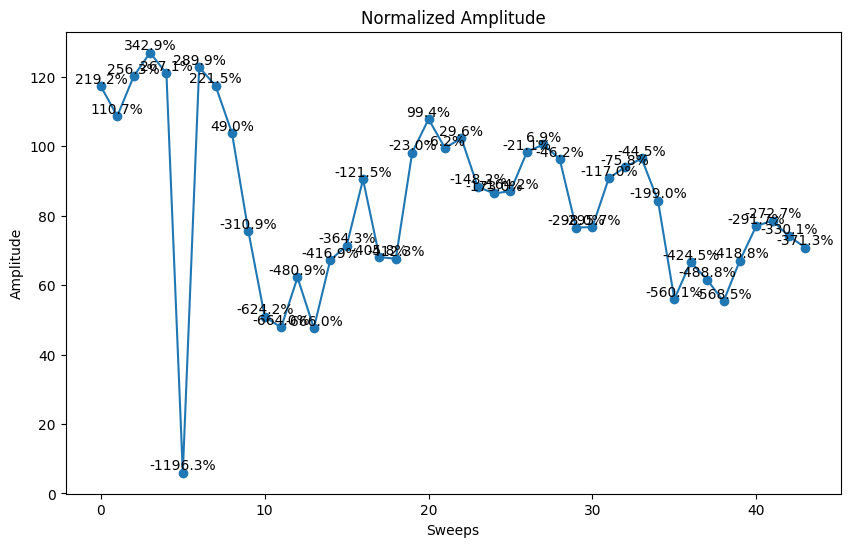

In [512]:
# Plotting the normalized amplitude
# change figure size
plt.figure(figsize=(10, 6))

plt.plot(df['normalized_amplitude'], marker='o', linestyle='-')  # Adding marker='o' to show each data point

# Annotating each point with the percent change
for index, (amp, percent) in enumerate(zip(df['normalized_amplitude'], df['percent_change'])):
    plt.text(index, amp, f"{percent:.1f}%", ha='center', va='bottom',fontsize = 10)  # Formatting the text to show one decimal place

plt.xlabel('Sweeps')
plt.ylabel('Amplitude')
plt.title('Normalized Amplitude')
plt.savefig(f'plots/normalized_amplitude_percents_{date}_{cell_number}.png')
plt.show()


/var/folders/mc/qbcjsrl16h3gf6t6xvz8czzw0000gn/T/ipykernel_13640/2101451219.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_drugs))  # Use a colormap with enough colors


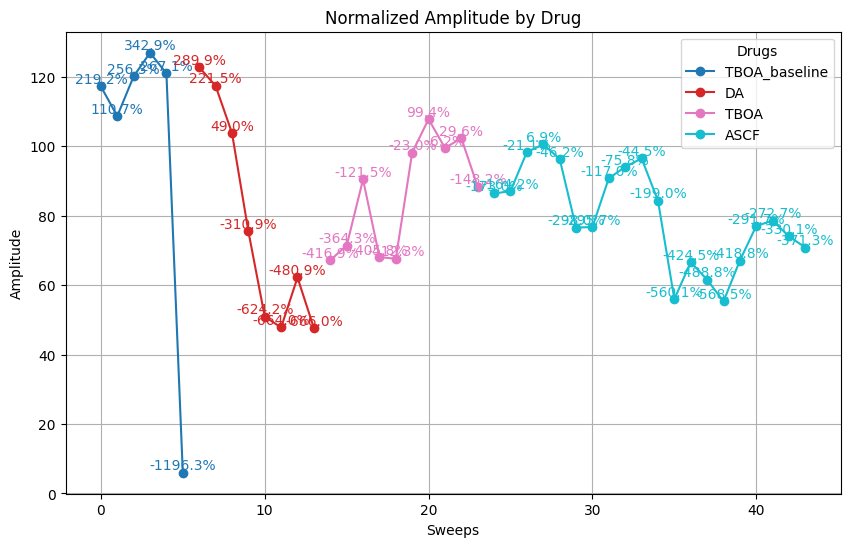

In [513]:

# Set the figure size
plt.figure(figsize=(10, 6))

# Get unique drugs and assign colors
unique_drugs = df['drug'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_drugs))  # Use a colormap with enough colors
color_dict = {drug: colors(i) for i, drug in enumerate(unique_drugs)}

# Plot each drug's data points with annotation
for drug in unique_drugs:
    # Filter the DataFrame for the current drug
    drug_df = df[df['drug'] == drug]
    plt.plot(drug_df.index, drug_df['normalized_amplitude'], marker='o', linestyle='-', color=color_dict[drug])
    for index, amp, percent in zip(drug_df.index, drug_df['normalized_amplitude'], drug_df['percent_change']):
        plt.text(index, amp, f"{percent:.1f}%", ha='center', va='bottom', fontsize=10, color=color_dict[drug])

plt.xlabel('Sweeps')
plt.ylabel('Amplitude')
plt.title('Normalized Amplitude by Drug')
plt.grid(True)
plt.legend(unique_drugs, title="Drugs")
plt.savefig(f'plots/normalized_amplitude_percents_colored_{date}_{cell_number}.png')
plt.show()

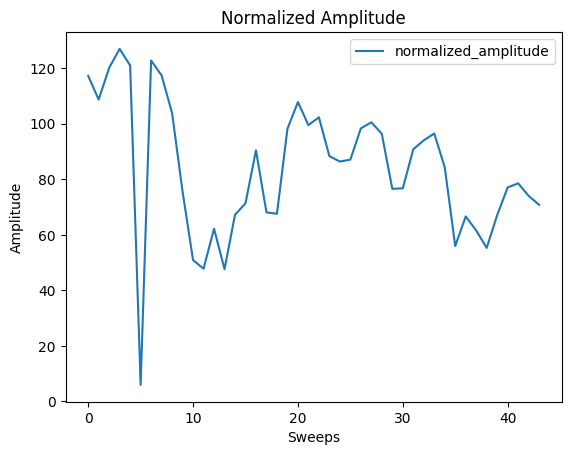

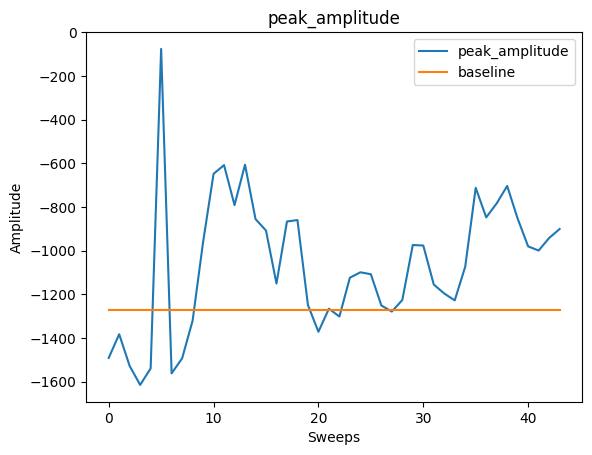

In [514]:
plt.plot(df['normalized_amplitude'])
plt.xlabel('Sweeps')
plt.ylabel('Amplitude')
plt.title('Normalized Amplitude')
plt.legend(['normalized_amplitude'])
plt.savefig(f'plots/normalized_amplitude_{date}_{cell_number}.png')
plt.show()


plt.show()
plt.plot(df['peak_amplitude'])
plt.plot(df['baseline'])
plt.xlabel('Sweeps')
plt.ylabel('Amplitude')
plt.title('peak_amplitude')
plt.legend(['peak_amplitude', 'baseline'])
plt.savefig(f'plots/normalized_amplitude_baseline_{date}_{cell_number}.png')

plt.show()

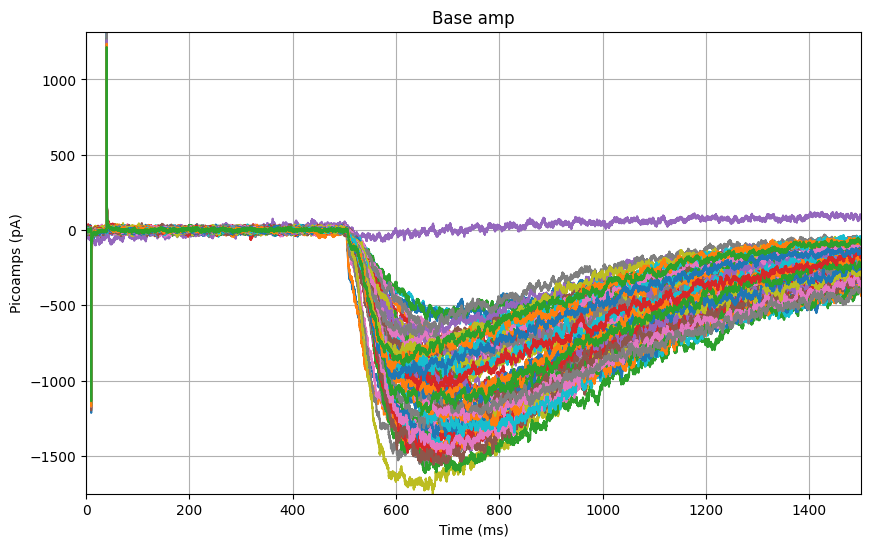

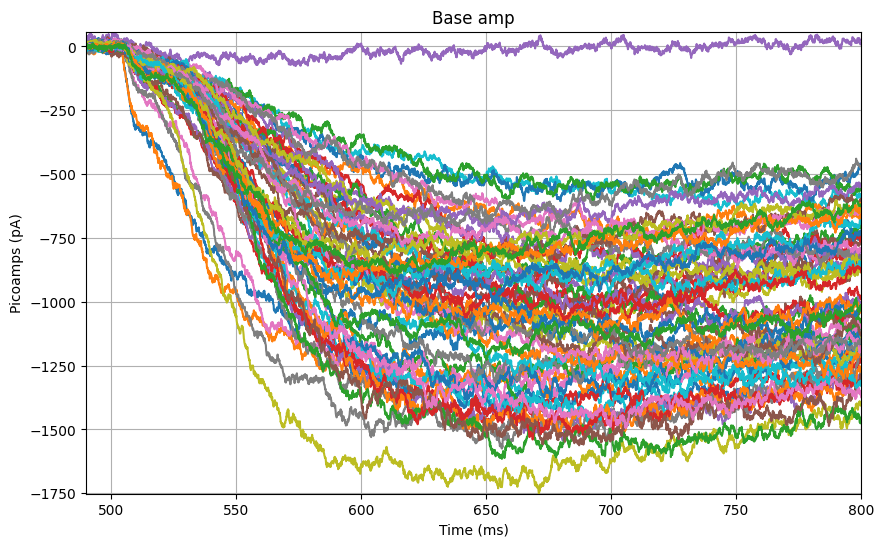

In [515]:
patch.plot_min_max_sweeps(0,1500,0,total_sweeps)
plt.savefig(f'sweep_plots/min_max_sweeps_full_{date}_{cell_number}.png')

patch.plot_min_max_sweeps(490,800,0,total_sweeps)
plt.savefig(f'sweep_plots/min_max_sweeps_{date}_{cell_number}.png')



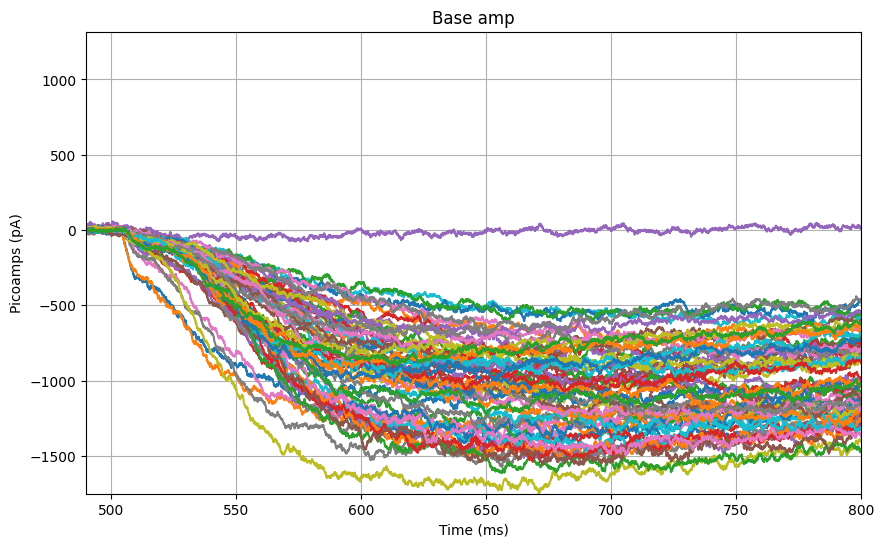

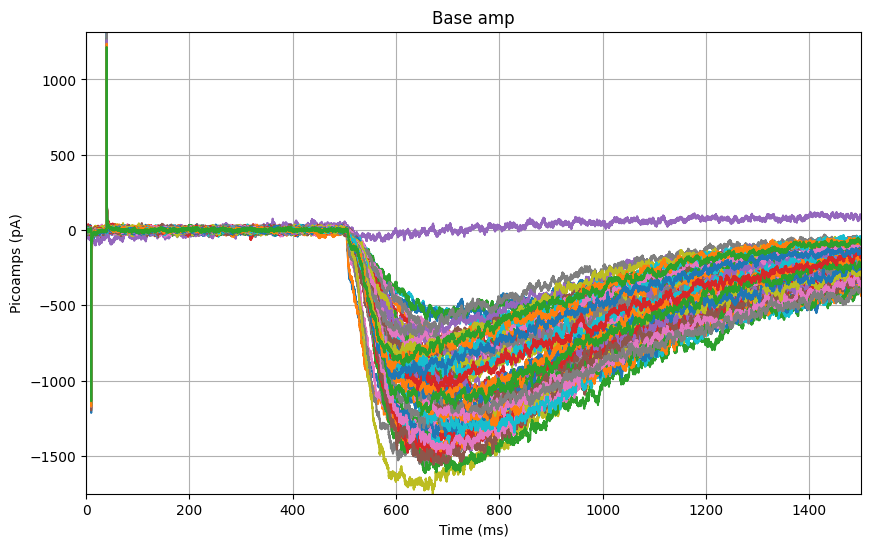

In [516]:
patch.plot_sweeps(490,800,0,total_sweeps)
plt.savefig(f'sweep_plots/peak_amp_window_{date}_{cell_number}.png')

patch.plot_sweeps(0,1500,0,total_sweeps)
plt.savefig(f'sweep_plots/full_sweep_{date}_{cell_number}.png')

